In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('ACSDP5Y2015.DP04_2021-01-18T135221/ACSDP5Y2015.DP04_data_with_overlays_2021-01-18T134919.csv', header=1)

# original analysis pop is B01003 2015
# original analysis dollars is S2001 2015, total workers * mean earnings

/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,9,12,13,18,19,28,29,32,33,36,37,40,41,44,45,48,49,52,53,56,57,60,61,68,69,72,73,76,77,80,81,84,85,88,89,92,93,96,97,100,101,104,105,112,113,116,117,120,121,124,125,128,129,132,133,136,137,140,141,144,145,156,157,160,161,164,165,168,169,172,173,176,177,184,185,188,189,204,205,208,209,212,213,216,217,220,221,224,225,232,233,236,237,240,241,244,245,252,253,256,257,260,261,264,265,268,269,272,273,276,277,280,281,285,286,292,293,296,297,298,299,300,301,308,309,312,313,316,317) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
hh_inc = pd.read_csv('ACSST5Y2015.S1901_2021-01-18T094336/ACSST5Y2015.S1901_data_with_overlays_2021-01-18T094056.csv',header=1)[['id','Households!!Estimate!!Mean income (dollars)']].rename(columns={'Households!!Estimate!!Mean income (dollars)':'mean_hh_inc'})
hh_inc['GEOID'] = hh_inc.apply(lambda row: int(row.id[-11:]),axis=1)



In [4]:
data_sub = data[['id','Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
'Estimate!!HOUSING TENURE!!Occupied housing units!!Owner-occupied',
'Estimate!!HOUSING TENURE!!Occupied housing units!!Renter-occupied',
'Estimate!!MORTGAGE STATUS!!Owner-occupied units!!Housing units with a mortgage',
'Estimate!!MORTGAGE STATUS!!Owner-occupied units!!Housing units without a mortgage',
'Estimate!!SELECTED MONTHLY OWNER COSTS (SMOC)!!Housing units with a mortgage!!Median (dollars)',
'Estimate!!SELECTED MONTHLY OWNER COSTS (SMOC)!!Housing units without a mortgage!!Median (dollars)',
'Estimate!!GROSS RENT!!Occupied units paying rent!!Median (dollars)']]
data_sub['GEOID'] = data_sub.apply(lambda row: int(row.id[-11:]),axis=1)

/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [5]:
data_sub = data_sub.rename(columns = {'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units':'total_units'})
data_sub['households'] = data_sub['Estimate!!HOUSING TENURE!!Occupied housing units!!Owner-occupied'] + data_sub['Estimate!!HOUSING TENURE!!Occupied housing units!!Renter-occupied']


In [18]:
rent = pd.read_csv('gross_rent/gross_rent.csv',header=1)
mort = pd.read_csv('agg_mortg/agg_mortg.csv',header=1)
rent = rent.replace('-',np.nan).dropna()
mort = mort.replace('-',np.nan).dropna()
rent['GEOID'] = rent.apply(lambda row: int(row.id[-11:]),axis=1)
mort['GEOID'] = mort.apply(lambda row: int(row.id[-11:]),axis=1)

housing_cost = pd.merge(data_sub[['GEOID','households']], rent[['GEOID','Estimate!!Aggregate gross rent']], on = 'GEOID').rename(columns = {'Estimate!!Aggregate gross rent':'rent'})
housing_cost = pd.merge(housing_cost, mort[['GEOID','Estimate!!Aggregate selected monthly owner costs (dollars)']], on = 'GEOID').rename(columns = {'Estimate!!Aggregate selected monthly owner costs (dollars)':'moc'})
housing_cost['housing_cost'] =(housing_cost.rent.astype(float) + housing_cost.moc.astype(float))*12
# housing_cost = pd.merge(housing_cost, data_pct[['GEOID','ave']],on="GEOID")
housing_cost = pd.merge(housing_cost, hh_inc[['GEOID','mean_hh_inc']], on='GEOID')
ct_deciles = pd.read_csv('ct_deciles.csv')
ct_pop = ct_deciles.groupby('ct').agg({'ct.population':'sum'}).rename(columns = {'ct.population':'ct_totalpop'}).reset_index()
ct_deciles = ct_deciles.merge(ct_pop,on='ct')
ct_deciles['pct'] = ct_deciles['ct.population']/ct_deciles['ct_totalpop']
ct_deciles.head()

housing_cost = housing_cost.merge(ct_deciles[['ct','ct.population','dec','ct.meandollars','msa','ct.totaldollars','pct']].rename(columns={'ct.meandollars':'mn','ct.totaldollars':'tot_inc','ct.population':'tot'}), left_on = 'GEOID',right_on='ct')
housing_cost['tot_inc'] = housing_cost.mn.astype(float)*housing_cost.tot.astype(int)
housing_cost['tot_hh_inc'] = housing_cost.mean_hh_inc.astype(float)*housing_cost.households.astype(int)*housing_cost.pct
housing_cost.head()
msa_tots = housing_cost.groupby('msa').agg({'housing_cost':'sum','households':'sum','tot_inc':'sum','tot':'sum'}).reset_index().rename(columns = {'tot':'msa_pop','housing_cost':'msa_housingcost','households':'msa_hh','tot_inc':'msa_inc'})
housing_cost = housing_cost.merge(msa_tots,on='msa')
housing_cost = housing_cost.merge(ct_pop,on='ct')
housing_cost['housing_cost_pct'] = housing_cost['housing_cost']*housing_cost['pct']




### Table S1

In [12]:
example_dec = ct_deciles[ct_deciles.msa==10140].rename(columns={'ct.totaldollars':'CT total income','ct.meandollars':'CT mean income','pop.sum':'MSA population','dollars.sum':'MSA total income','dec':'decile','ct_totalpop':'CT total population','ct.population':'CT population (this decile)','ct': 'CT ID','msa':'MSA ID'}).sort_values('CT mean income')[['MSA ID','MSA population','decile','CT ID','CT mean income','CT total population','CT population (this decile)']]
example_dec['decile population'] = example_dec['MSA population']/10
example_dec.head(8)

,MSA ID,MSA population,decile,CT ID,CT mean income,CT total population,CT population (this decile),decile population
0,10140,102471,1,53027001600,36011,6547.0,6547.0,10247.1
1,10140,102471,1,53027001200,37891,4514.0,3700.1,10247.1
2,10140,102471,2,53027001200,37891,4514.0,813.9,10247.1
3,10140,102471,2,53031950702,39852,4416.0,2208.0,10247.1
5,10140,102471,2,53049950300,40336,3613.0,3613.0,10247.1
6,10140,102471,2,53027940000,40611,1106.0,1106.0,10247.1
7,10140,102471,2,53045960100,41041,1396.0,698.0,10247.1
9,10140,102471,2,53027001000,41552,3544.0,1808.2,10247.1


In [13]:
example_dec.head(8).to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &  MSA ID &  MSA population &  decile &        CT ID &  CT mean income &  CT total population &  CT population (this decile) &  decile population \\\\\n\\midrule\n0 &   10140 &          102471 &       1 &  53027001600 &           36011 &               6547.0 &                       6547.0 &            10247.1 \\\\\n1 &   10140 &          102471 &       1 &  53027001200 &           37891 &               4514.0 &                       3700.1 &            10247.1 \\\\\n2 &   10140 &          102471 &       2 &  53027001200 &           37891 &               4514.0 &                        813.9 &            10247.1 \\\\\n3 &   10140 &          102471 &       2 &  53031950702 &           39852 &               4416.0 &                       2208.0 &            10247.1 \\\\\n5 &   10140 &          102471 &       2 &  53049950300 &           40336 &               3613.0 &                       3613.0 &            10247.1 \\\\\n6 &   10140 &          

In [21]:
dec1 = housing_cost[housing_cost.dec==1].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec2 = housing_cost[housing_cost.dec==2].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec3 = housing_cost[housing_cost.dec==3].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec4 = housing_cost[housing_cost.dec==4].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec5 = housing_cost[housing_cost.dec==5].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec6 = housing_cost[housing_cost.dec==6].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec7 = housing_cost[housing_cost.dec==7].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec8 = housing_cost[housing_cost.dec==8].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec9 = housing_cost[housing_cost.dec==9].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()
dec10 = housing_cost[housing_cost.dec==10].groupby(['msa','msa_inc','msa_pop']).agg({'tot_inc':'sum','housing_cost_pct':'sum','households':'sum','tot':'sum','tot_hh_inc':'sum'}).reset_index()

### Dependent variable: total household income

[1.0126632430875828,
 1.0503920147354338,
 1.080012119864983,
 1.1190118593416498,
 1.1406323812206765,
 1.171340088494192,
 1.197191983162793,
 1.2128283756248812,
 1.2359163734395076,
 1.2672016363495964]

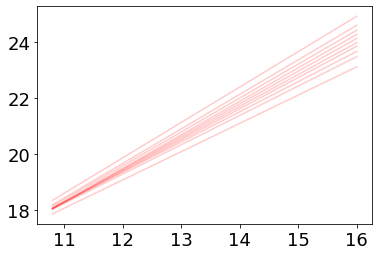

In [47]:
coefs0 = []
consts0 = []
erhi0 = []
erlo0 = []
rsquareds0 = []
for dec in [dec1,dec2,dec3,dec4,dec5,dec6,dec7,dec8,dec9,dec10]:
    log_pop = sm.add_constant(np.log(dec.msa_pop).astype(float))
    log_dol = np.log(dec['tot_hh_inc'].astype(float))#/np.log(dec['ct.totaldollars'].astype(float))
    overall_mod = sm.OLS(log_dol, log_pop).fit()
    coefs0.append(overall_mod.params[1])
    consts0.append(overall_mod.params[0])
    erhi0.append(overall_mod.conf_int(.05).loc['msa_pop'][1])
    erlo0.append(overall_mod.conf_int(.05).loc['msa_pop'][0])
    rsquareds0.append(overall_mod.rsquared)
    x = np.linspace(10.8, 16,100)
    y = overall_mod.params[1]*x+overall_mod.params[0]
    plt.plot(x, y, '-r',alpha=.2)
coefs0

In [48]:
rsquareds0

[0.8792834266691263,
 0.9253488333744968,
 0.9331962214585734,
 0.9393905707690905,
 0.9388129562234756,
 0.941064634706634,
 0.9434950896317069,
 0.9421160784348505,
 0.9424040198123312,
 0.9408350277812686]

### Dependent variable: total housing cost

[1.1087129076027384,
 1.134562964538891,
 1.1600682209768378,
 1.1880032027771557,
 1.2072023065672592,
 1.2351274177973222,
 1.2535832366867687,
 1.2673664813942216,
 1.2849141294245814,
 1.2904203024571397]

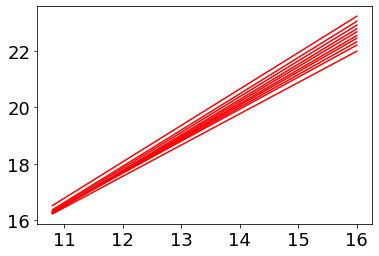

In [49]:
coefs1 = []
consts1 = []
erhi1 = []
erlo1 = []
rsquareds1 = []
for dec in [dec1,dec2,dec3,dec4,dec5,dec6,dec7,dec8,dec9,dec10]:
    log_pop = sm.add_constant(np.log(dec.msa_pop).astype(float))
    log_dol = np.log(dec['housing_cost_pct'].astype(float))#/np.log(dec['ct.totaldollars'].astype(float))
    overall_mod = sm.OLS(log_dol, log_pop).fit()
    coefs1.append(overall_mod.params[1])
    consts1.append(overall_mod.params[0])
    erhi1.append(overall_mod.conf_int(.05).loc['msa_pop'][1])
    erlo1.append(overall_mod.conf_int(.05).loc['msa_pop'][0])
    rsquareds1.append(overall_mod.rsquared)
    x = np.linspace(10.8, 16,100)
    y = overall_mod.params[1]*x+overall_mod.params[0]
    plt.plot(x, y, '-r')
coefs1

In [50]:
rsquareds3

[0.21182542580117436,
 0.19690053864230328,
 0.2126504314674692,
 0.18242102765192103,
 0.1673050989090198,
 0.17550346547042006,
 0.13077438090689286,
 0.13554962246544588,
 0.10866847603092511,
 0.022694138782014428]

### Dependent variable: total housing cost/total household income

[0.022371092417190763,
 0.01801116001211801,
 0.016332973084449327,
 0.013784263126472978,
 0.012839611863003846,
 0.012177449381679403,
 0.01049374536580861,
 0.009988322642803945,
 0.00863760168154866,
 0.003606224118788202]

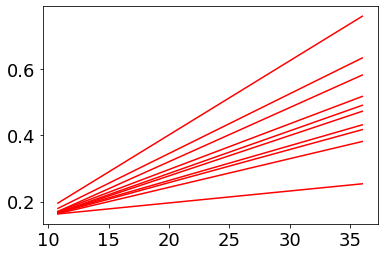

In [51]:
coefs3 = []
consts3 = []
erhi3 = []
erlo3 = []
rsquareds3 = []
for dec in [dec1,dec2,dec3,dec4,dec5,dec6,dec7,dec8,dec9,dec10]:
    log_pop = sm.add_constant(np.log(dec.msa_pop).astype(float))
    log_dol = (dec['housing_cost_pct'].astype(float)/dec['tot_hh_inc'])#/np.log(dec['ct.totaldollars'].astype(float))
    overall_mod = sm.OLS(log_dol, log_pop).fit()
    coefs3.append(overall_mod.params[1])
    consts3.append(overall_mod.params[0])
    erhi3.append(overall_mod.conf_int(.05).loc['msa_pop'][1])
    erlo3.append(overall_mod.conf_int(.05).loc['msa_pop'][0])
    rsquareds3.append(overall_mod.rsquared)
    x = np.linspace(10.8, 36,100)
    y = overall_mod.params[1]*x+overall_mod.params[0]
    plt.plot(x, y, '-r')
coefs3

In [52]:
rsquareds1

[0.8910644210256772,
 0.9145445845665634,
 0.9181152229801324,
 0.9270526479464306,
 0.9269551049685486,
 0.9307751453051879,
 0.9323382262039855,
 0.9346642695397187,
 0.9340820873565133,
 0.9367856776262745]

### Dependent variable: total income - total housing cost

[0.9832245000615828,
 1.0272618163573126,
 1.0592991900398387,
 1.10165398503436,
 1.12462854195869,
 1.1561980697362138,
 1.1842315660885956,
 1.2005437379758594,
 1.2253916528488307,
 1.2629269456680834]

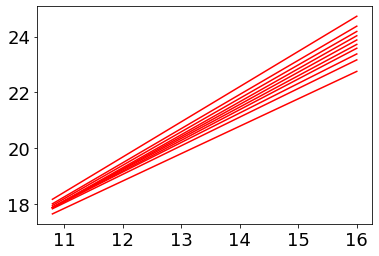

In [58]:
coefs2 = []
consts2 = []
erhi2 = []
erlo2 = []
rsquareds2 = []
for dec in [dec1,dec2,dec3,dec4,dec5,dec6,dec7,dec8,dec9,dec10]:
    log_pop = sm.add_constant(np.log(dec.msa_pop).astype(float))
    log_dol = np.log(dec['tot_hh_inc'].astype(float) - dec['housing_cost_pct'].astype(float))#/np.log(dec['ct.totaldollars'].astype(float))
    overall_mod = sm.OLS(log_dol, log_pop).fit()
    coefs2.append(overall_mod.params[1])
    consts2.append(overall_mod.params[0])
    erhi2.append(overall_mod.conf_int(.05).loc['msa_pop'][1])
    erlo2.append(overall_mod.conf_int(.05).loc['msa_pop'][0])
    rsquareds2.append(overall_mod.rsquared)
    x = np.linspace(10.8, 16,100)
    y = overall_mod.params[1]*x+overall_mod.params[0]
    plt.plot(x, y, '-r')
coefs2

In [31]:
rsquareds2

[0.9343257226845124,
 0.9827707259597576,
 0.9864173527332478,
 0.9849030845641078,
 0.9860580624563163,
 0.986287290417231,
 0.9856869430802366,
 0.9835660949917366,
 0.9831116376220524,
 0.9784498845911798]

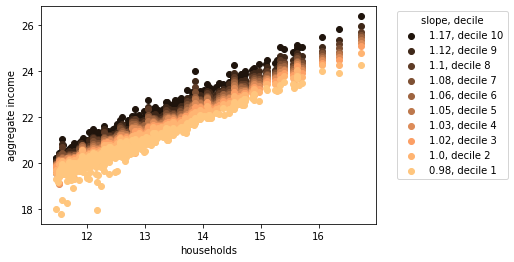

In [31]:
import matplotlib.pyplot as plt
plt.scatter(np.log(dec10['msa_pop'].astype(float)),np.log(dec10['tot_inc'].astype(float)-dec10['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.1),label=str(round(coefs0[9],2)) + ', decile 10')
plt.scatter(np.log(dec9['msa_pop'].astype(float)),np.log(dec9['tot_inc'].astype(float)-dec9['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.2),label=str(round(coefs0[8],2))+ ', decile 9')
plt.scatter(np.log(dec8['msa_pop'].astype(float)),np.log(dec8['tot_inc'].astype(float)-dec8['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.3),label=str(round(coefs0[7],2))+ ', decile 8')

plt.scatter(np.log(dec7['msa_pop'].astype(float)),np.log(dec7['tot_inc'].astype(float)-dec7['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.4),label=str(round(coefs0[6],2))+ ', decile 7')
plt.scatter(np.log(dec6['msa_pop'].astype(float)),np.log(dec6['tot_inc'].astype(float)-dec6['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.5),label=str(round(coefs0[5],2))+ ', decile 6')
plt.scatter(np.log(dec5['msa_pop'].astype(float)),np.log(dec5['tot_inc'].astype(float)-dec5['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.6),label=str(round(coefs0[4],2))+ ', decile 5')
plt.scatter(np.log(dec4['msa_pop'].astype(float)),np.log(dec4['tot_inc'].astype(float)-dec4['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.7),label=str(round(coefs0[3],2))+ ', decile 4')
plt.scatter(np.log(dec3['msa_pop'].astype(float)),np.log(dec3['tot_inc'].astype(float)-dec3['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.8),label=str(round(coefs0[2],2))+ ', decile 3')

plt.scatter(np.log(dec2['msa_pop'].astype(float)),np.log(dec2['tot_inc'].astype(float)-dec2['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.9),label=str(round(coefs0[1],2))+ ', decile 2')
plt.scatter(np.log(dec1['msa_pop'].astype(float)),np.log(dec1['tot_inc'].astype(float)-dec1['housing_cost_pct'].astype(float)), color = plt.get_cmap('copper')(.99),label=str(round(coefs0[0],2))+ ', decile 1')
plt.xlabel('households')
plt.ylabel('aggregate income')
plt.legend(title = 'slope, decile', bbox_to_anchor=(1.05, 1))


Text(0, 0.5, 'housing cost/income')

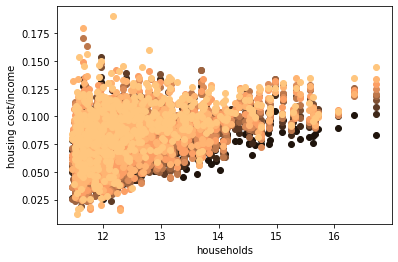

In [14]:
plt.scatter(np.log(dec10['msa_pop'].astype(float)),dec10['housing_cost_pct'].astype(float)/dec10['tot_inc'].astype(float), color = plt.get_cmap('copper')(.1))
plt.scatter(np.log(dec9['msa_pop'].astype(float)),dec9['housing_cost_pct'].astype(float)/dec9['tot_inc'].astype(float), color = plt.get_cmap('copper')(.2))
plt.scatter(np.log(dec8['msa_pop'].astype(float)),dec8['housing_cost_pct'].astype(float)/dec8['tot_inc'].astype(float), color = plt.get_cmap('copper')(.3))

plt.scatter(np.log(dec7['msa_pop'].astype(float)),dec7['housing_cost_pct'].astype(float)/dec7['tot_inc'].astype(float), color = plt.get_cmap('copper')(.4))
plt.scatter(np.log(dec6['msa_pop'].astype(float)),dec6['housing_cost_pct'].astype(float)/dec6['tot_inc'].astype(float), color = plt.get_cmap('copper')(.5))
plt.scatter(np.log(dec5['msa_pop'].astype(float)),dec5['housing_cost_pct'].astype(float)/dec5['tot_inc'].astype(float), color = plt.get_cmap('copper')(.6))
plt.scatter(np.log(dec4['msa_pop'].astype(float)),dec4['housing_cost_pct'].astype(float)/dec4['tot_inc'].astype(float), color = plt.get_cmap('copper')(.7))
plt.scatter(np.log(dec3['msa_pop'].astype(float)),dec3['housing_cost_pct'].astype(float)/dec3['tot_inc'].astype(float), color = plt.get_cmap('copper')(.8))

plt.scatter(np.log(dec2['msa_pop'].astype(float)),dec2['housing_cost_pct'].astype(float)/dec2['tot_inc'].astype(float), color = plt.get_cmap('copper')(.9))
plt.scatter(np.log(dec1['msa_pop'].astype(float)),dec1['housing_cost_pct'].astype(float)/dec1['tot_inc'].astype(float), color = plt.get_cmap('copper')(.99))
plt.xlabel('households')
plt.ylabel('housing cost/income')

### Figure 4

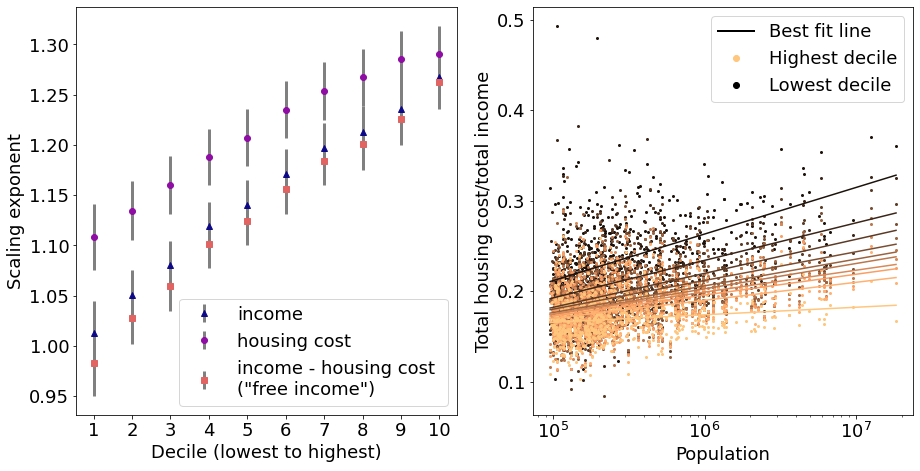

In [59]:
import matplotlib.lines as mlines
# legend cheats
blueline = mlines.Line2D([], [], marker="None", linestyle='-',linewidth=2, label= "Best fit line",color='black' )
magdots = mlines.Line2D([], [],marker="o", linestyle='None',label= "Highest decile",color=plt.get_cmap('copper')(.99))
greendash = mlines.Line2D([], [],marker="o", linestyle='None',label= "Lowest decile",color=plt.get_cmap('copper')(0))

coefs3 = []
consts3 = []
erhi3 = []
erlo3 = []
decs = [dec1,dec2,dec3,dec4,dec5,dec6,dec7,dec8,dec9,dec10]
fig, axs = plt.subplots(1,2,figsize=(15,7.5))
plt.rcParams.update({'font.size': 18})
axs[1].legend(handles = [blueline, magdots, greendash ])

for i in range(10):
    dec = decs[i]
    log_pop_only = np.log((dec.msa_pop).astype(float))
    pop_only = (dec.msa_pop).astype(float)
    log_pop = sm.add_constant(np.log(dec.msa_pop).astype(float))
    log_dol =  dec['housing_cost_pct'].astype(float)/dec['tot_hh_inc'].astype(float)#/np.log(dec['ct.totaldollars'].astype(float))
    overall_mod = sm.OLS(log_dol, log_pop).fit()
    coefs3.append(overall_mod.params[1])
    consts3.append(overall_mod.params[0])
    erhi3.append(overall_mod.conf_int(.05).loc['msa_pop'][1])
    erlo3.append(overall_mod.conf_int(.05).loc['msa_pop'][0])
    x = np.linspace(min(pop_only), max(pop_only),100)
    y = np.log(x)*overall_mod.params[1]+(overall_mod.params[0])
    axs[1].plot(x, y, label=str(i+1), color = plt.get_cmap('copper')((i+1)/10-.01))
    axs[1].scatter(pop_only, log_dol, color = plt.get_cmap('copper')((i+1)/10-.01),s=4)
    axs[1].set_xlabel('Population',size=18)
    axs[1].set_ylabel('Total housing cost/total income',size=18)
    axs[1].set_xscale('log')
    #plt.legend(title = 'decile', bbox_to_anchor=(1.15, 1))
    #fig.text(0.5, .9, 'Percent of total income spent on housing', ha='center',size=28)
coefs2
#fig.savefig('housing_cost_pct.png')
axs[0].errorbar(range(1,11),coefs0, yerr = [(coefs0[j]-erlo0[j]) for j in range(10)], fmt='^', ecolor='gray', elinewidth=3, label='income', color=plt.get_cmap('plasma')(0))
axs[0].errorbar(range(1,11),coefs1, yerr = [(coefs1[j]-erlo1[j]) for j in range(10)], fmt='o', ecolor='gray', elinewidth=3, label='housing cost', color=plt.get_cmap('plasma')(.3))
axs[0].errorbar(range(1,11),coefs2, yerr = [(coefs2[j]-erlo2[j]) for j in range(10)], fmt='s', ecolor='gray', elinewidth=3, label='income - housing cost \n("free income")', color=plt.get_cmap('plasma')(.6))
axs[0].set_xlabel('Decile (lowest to highest)')
axs[0].set_ylabel('Scaling exponent')
axs[0].set_xticks(np.arange(1, 11, 1.0))
axs[0].legend()
plt.savefig('housing_cost_norm.png')
